In [16]:
# DON T TOUCH
import numpy as np
import scipy.sparse as sp
from sklearn.neighbors import NearestNeighbors

class Isomap:
    def __init__(self, n_components=2, n_neighbors=5):
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.graph_ = None
        self.embedding_ = None

    def fit_transform(self, X):
        # Compute pairwise distances
        knn = NearestNeighbors(n_neighbors=self.n_neighbors+1)
        knn.fit(X)
        distances, indices = knn.kneighbors(X)
        distances = distances[:, 1:]
        indices = indices[:, 1:]

        # Build neighborhood graph
        n_samples = X.shape[0]
        row_indices = np.repeat(np.arange(n_samples), self.n_neighbors)
        col_indices = indices.ravel()
        data = distances.ravel()
        self.graph_ = sp.csr_matrix((data, (row_indices, col_indices)), shape=(n_samples, n_samples))

        # Compute shortest path distances
        dist_matrix = sp.csgraph.shortest_path(self.graph_, method='D')

        # Apply MDS to the distance matrix
        dist_centered = dist_matrix - np.mean(dist_matrix, axis=0)
        dist_centered -= np.mean(dist_centered, axis=1)[:, np.newaxis]
        eig_vals, eig_vecs = np.linalg.eigh(np.dot(dist_centered, dist_centered.T))
        eig_vals[::-1].sort()
        eig_vecs = eig_vecs[:, ::-1]

        # Compute final embedding
        self.embedding_ = np.dot(eig_vecs[:, :self.n_components], np.sqrt(np.diag(eig_vals[:self.n_components])))

        return self.embedding_


In [4]:
import numpy as np
import scipy.sparse as sp
from sklearn.neighbors import NearestNeighbors, kneighbors_graph

class Isomap:
    def __init__(self, n_components=2, n_neighbors=5):
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.graph_ = None
        self.embedding_ = None

    def fit_transform(self, X):
        # Compute pairwise distances
        self.graph_ = kneighbors_graph(X, n_neighbors= self.n_neighbors ).toarray()
        

        # Compute shortest path distances
        D = sp.csgraph.shortest_path(self.graph_, method='D')


        # Apply MDS to the distance matrix
        # double center
        n = D.shape[0]
        one_n = np.ones((n, n)) / n
        G = (D - one_n.dot(D) - D.dot(one_n) + one_n.dot(D).dot(one_n))
        G = -(1/2 )* G

        eig_vals, eig_vecs = np.linalg.eigh(G)
        eig_vals = np.where(eig_vals<0,0, eig_vals)
        sorted_indices = np.argsort(eig_vals)[::-1]
        sorted_eigvecs = eig_vecs[:,sorted_indices]
        sorted_eigvals = eig_vals[sorted_indices]

        # select the first k eigenvector(s) and project
        top_k_eigvecs = sorted_eigvecs[:,:self.n_components]
        top_k_eigvals = sorted_eigvals[:self.n_components]


        # Compute final embedding
        self.embedding_ = np.dot(top_k_eigvecs, np.sqrt(np.diag(top_k_eigvals)))

        return self.embedding_


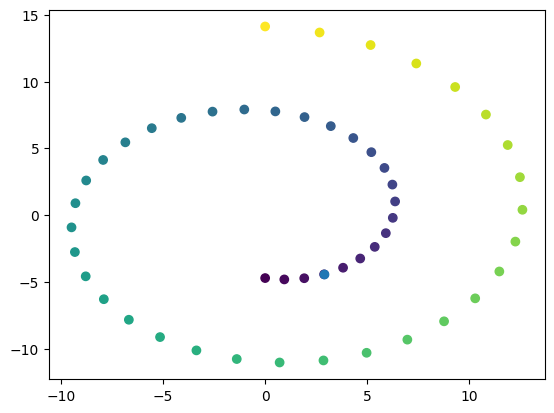

In [5]:
import math
from matplotlib import pyplot as plt
N = 50

phi = np.linspace(1.5*math.pi, 4.5*math.pi, N)

x = phi*np.cos(phi)
y = phi*np.sin(phi)

X = np.array([x,y]).reshape(2,N).T

plt.scatter(x,y, c = phi)

plt.scatter(X[3,0], X[3,1])


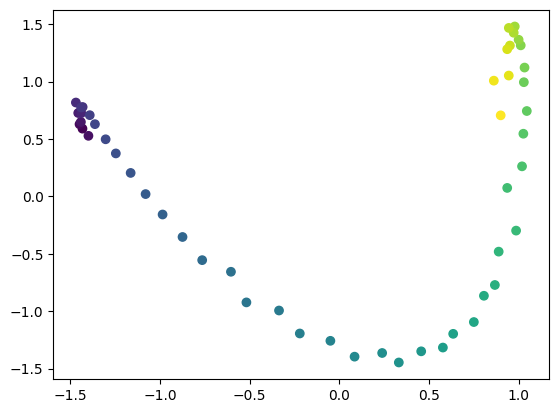

In [6]:
map = Isomap(n_components=2)
Y = map.fit_transform(X)


plt.scatter(Y[:,0], Y[:,1], c = phi)

In [8]:
Y.shape

(50, 2)

# Another

In [1]:
import numpy as np
import scipy.sparse as sp
from sklearn.neighbors import kneighbors_graph

class Isomap:
    def __init__(self, n_components=2, n_neighbors=5):
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.graph_ = None
        self.embedding_ = None

    def fit_transform(self, X):
        # Compute pairwise distances
        self.graph_ = kneighbors_graph(X, n_neighbors= self.n_neighbors ).toarray()

        # Compute shortest path distances
        D = sp.csgraph.shortest_path(self.graph_, method='D')

        for i in range((D.shape[0])):
            for j in range((D.shape[0])):
                if D[i,j] != D[j,i]:
                    k = np.min([D[i,j], D[j,i]])
                    D[i,j] = k
                    D[j,i] = k

        # Apply MDS to the distance matrix
        # double center
        n = D.shape[0]
        one_n = np.ones((n, n)) / n
        G = (D - one_n.dot(D) - D.dot(one_n) + one_n.dot(D).dot(one_n))
        #G = -(1/2 )* G

        eig_vals, eig_vecs = np.linalg.eigh(G)
        sorted_indices = np.argsort(eig_vals)[::-1]
        sorted_eigvecs = eig_vecs[:,sorted_indices]

        # select the first k eigenvector(s) and project
        top_k_eigvecs = sorted_eigvecs[:,:self.n_components]

        projection_matrix = top_k_eigvecs.T

        return np.dot(X, projection_matrix)

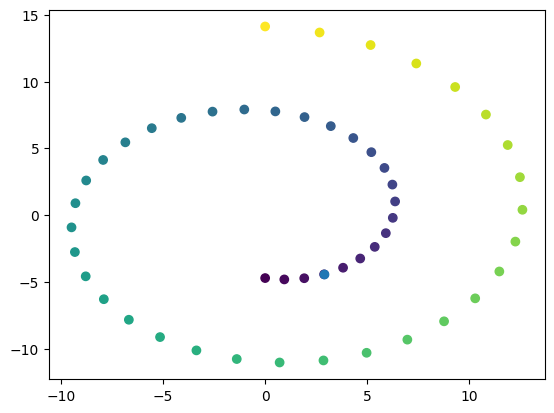

In [2]:
import math
from matplotlib import pyplot as plt
N = 50

phi = np.linspace(1.5*math.pi, 4.5*math.pi, N)

x = phi*np.cos(phi)
y = phi*np.sin(phi)

X = np.array([x,y]).reshape(2,N).T

plt.scatter(x,y, c = phi)

plt.scatter(X[3,0], X[3,1])


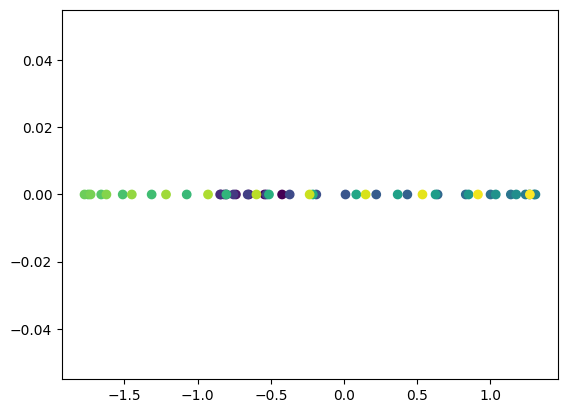

In [3]:
map = Isomap(n_components=2)
Y = map.fit_transform(X)

plt.scatter(Y[:,0], np.zeros(X.shape[0]), c = phi)

(50, 50)

In [4]:
print(map.graph_)

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [8]:
import networkx as nx
import random

# Create an empty directed graph
G = nx.DiGraph()

nn = 5
# Add nodes (optional)
G.add_nodes_from(range(1, nn)) # Adds 10 nodes with IDs 1 to 10

# Add edges randomly
for i in range(1, nn):
    for j in range(1, nn):
        if i != j: # Avoid self-loops
           
            p = random.uniform(0, 1) # Random probability to add edge
            if p < 0.7: # Probability to add edge is 0.3 (30%)
                G.add_edge(i, j, weight=1)


In [17]:
D = sp.csgraph.shortest_path(nx.to_numpy_matrix(G), method='D')

D


array([[0., 1., 2., 1.],
       [1., 0., 1., 2.],
       [1., 2., 0., 2.],
       [2., 1., 2., 0.]])

In [21]:
for i in range((D.shape[0])):
    for j in range((D.shape[0])):
        if D[i,j] != D[j,i]:
            k = np.min([D[i,j], D[j,i]])
            D[i,j] = k
            D[j,i] = k
D

array([[0., 1., 1., 1.],
       [1., 0., 1., 1.],
       [1., 1., 0., 2.],
       [1., 1., 2., 0.]])

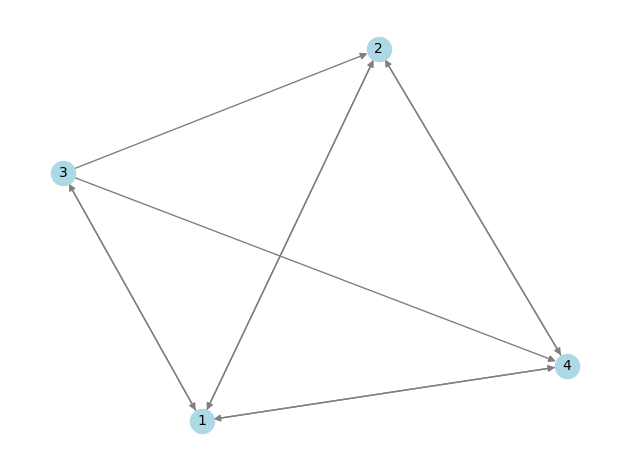

In [58]:
import networkx as nx
import matplotlib.pyplot as plt



# define the layout and style options
pos = nx.spring_layout(G, k=0.08, iterations=20)  # adjust k and iterations as needed
options = {
    "pos": pos,
    "with_labels": True,
    "node_color": 'lightblue',
    "edge_color": 'gray',
    "font_size": 10,
    "width": 1,
    "linewidths": 1,
    "node_size": 300,  # increase node size
}

# draw the graph and display it
nx.draw_networkx(G, **options)
plt.axis('off')
plt.tight_layout()
plt.show()
